In [1]:
import pyro
import pandas as pd
import numpy as np
import torch
import math
import os
import matplotlib.pyplot as plt
from pyro.infer import SVI, Predictive, TraceEnum_ELBO, config_enumerate
from pyro.optim import ClippedAdam
import pyro.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

from helper_functions.Clean_data import create_summed_df
from helper_functions.Preprocess_df import standardize_input, standardize_tensor, reverse_standardize_tensor
from helper_functions.utils import split_patient_level, summarize_columns, save_model_and_losses

# set random seed for reproducibility
np.random.seed(42)
pyro.set_rng_seed(0)

experiment_name = "testing_pca_mu_clamp_lower_var_alpha"
save_dir = os.path.join("outputs", experiment_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

c:\Users\marie\miniconda3\envs\mbml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data and prepare it

In [2]:
if not os.path.exists("data/CaseRigshospitalet_summed.parquet"):
    print("Creating data file")
    create_summed_df()
print("Loading data file")
df = pd.read_parquet("data/CaseRigshospitalet_summed.parquet")

print("Number of data points ", len(df))
print("Number of patients ", len(df["Patient ID"].unique()))
summarize_columns(df)

Loading data file
Number of data points  497198
Number of patients  331647
                           name     dtype  unique  size (MB)
0                    Patient ID  category  331647         30
1           Aktionsdiagnosekode  category    8167          1
2  totalDiagnoseKontaktVarighed   float32    8160          1
3                antalKontakter     int64     141          3
4                antalDiagnoser     int64      17          3
5                         alder   Float64   14014          4
6                        gender  category       4          0
7                    civilStand  category       4          0
8          distanceToHospitalKM   float64    1772          3
Total size (excluding "embedding"): 50.595398902893066 MB


### Create train and test data split

In [3]:
total_samples=100_000
(x_emb_train, d_demo_train, v_time_train, c_count_train), (x_emb_test, d_demo_test, v_time_test, c_count_test) = split_patient_level(df, total_samples=total_samples)

Demographic columns: ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt', 'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Ugift']


### Preprocess data
First, we standardize the input $x$ and $d$. Only age and distance is standardized of the $d$ since the other parts are one-hot-encodings. Then a PCA is done one the input $x$ to diminish the dimensions of the bert embeddings of the text, $x$, still covering 95% of the variance. 

In [5]:
x_emb_train_pca, x_emb_test_pca, d_demo_train, d_demo_test = standardize_input(x_emb_train, x_emb_test, d_demo_train, d_demo_test)
print("Standardized x_emb_train shape: ", x_emb_train_pca.shape)
print("Standardized x_emb_test shape: ", x_emb_test_pca.shape)
print("Standardized d_demo_train shape: ", d_demo_train.shape)  

Standardized x_emb_train shape:  torch.Size([79917, 150])
Standardized x_emb_test shape:  torch.Size([20083, 150])
Standardized d_demo_train shape:  torch.Size([79917, 8])


The output visitation time, $v$, is log transformed (to allow use of a normal function to estimate) and then standardized. The output visit count is not standardized as it does not make sense for count data. We plot the different versions of $v$.

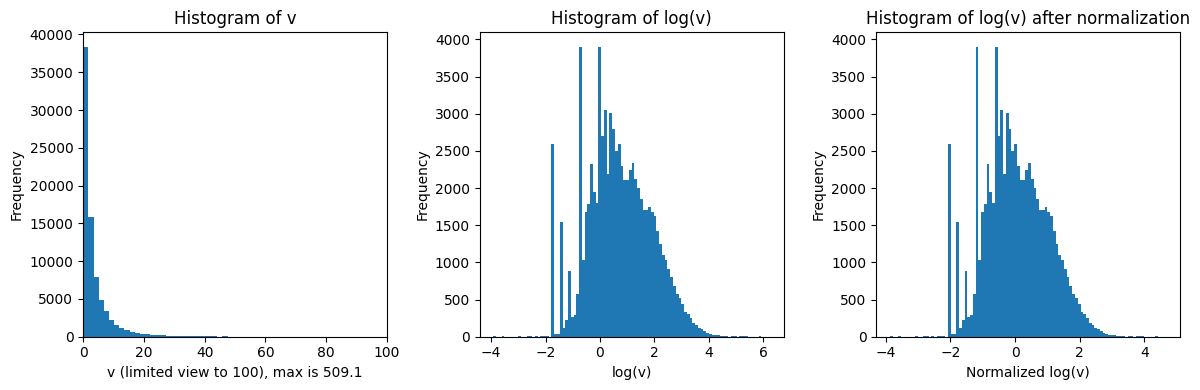

In [6]:

fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].hist(v_time_train, bins=300)
ax[0].set_title("Histogram of v")
ax[0].set_xlabel(f"v (limited view to 100), max is {torch.max(v_time_train):.1f}")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(0, 100)

v_time_train_log = torch.log(v_time_train)
#plot histogram of v_time_train_log
ax[1].hist(v_time_train_log.cpu().numpy(), bins=100)
ax[1].set_title("Histogram of log(v)")
ax[1].set_xlabel("log(v)")
ax[1].set_ylabel("Frequency")

v_time_train_log, v_time_mean, v_time_std = standardize_tensor(v_time_train_log)
ax[2].hist(v_time_train_log.cpu().numpy(), bins=100)
ax[2].set_title("Histogram of log(v) after normalization")
ax[2].set_xlabel("Normalized log(v)")
ax[2].set_ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "v_time_histograms.pdf"))
plt.show()

v_time_test_log = torch.log(v_time_test)
v_time_test_log, _, _ = standardize_tensor(v_time_test_log, v_time_mean, v_time_std)


## Train

The generative process we are training is below. 

**Generative Process:**

1) Draw $\theta \sim \text{Dirichlet}(\alpha)$

2) For each group, $g$, in $G$:

    2a) Draw $\beta_g \sim \mathcal{N}(0,\bm{I}_K)$

    2b) Draw $\bm\gamma_0^g \sim \mathcal{N}(\log(\mathbb{E}[\bm c]),1)$

    2b) Draw $\gamma^g_{K-1} \sim \mathcal{N}(0,\bm{I}_{K-1})$

    2c) Draw $\sigma_g \sim \text{HalfCauchy}(5)$

3) For each patient unique diagnosis record, $r$, in $\bm R$:

    3a) Draw group assignment $\bm{g}_r \sim \text{Categorical}(\theta)$

    3b) $\tilde{\mu} = \beta_{0}^r + \bm{\beta}_x^r \bm{x}_p + \bm{\beta}_d^r \bm{d}_p$
    
    3c) $\tilde{\lambda} = \exp (\gamma_{0}^r + \bm{\gamma}_x^r \bm{x}_r + \bm{\gamma}_d^r \bm{d}_r)$
    
    3d) Draw $\bm{v}_r \sim \text{LogNormal}(\tilde{\mu}, \sigma_{g_r})$ 
    
    3e) Draw $\bm{c}_r \sim \text{Poisson}(\tilde{\lambda})$ 

The $\gamma_0$ are initialized with a prior with the empiric average. The $\log \lambda$ is clamped within $[-5.0, 5.4]$ and $\mu$ is clamped within $[-5.0, 5.0]$ matching the min and max values of the empirical distribution. The model is defined below as well as a guide for training the model with stochastical variational inference.

In [ ]:
# Assume data tensors:
# x: [R, D_x] text embeddings
# d: [R, D_d] demographic features
# v: [R] visitation duration, continuous outcome
# c: [R] visitation count, positive integer outcome

torch.set_default_dtype(torch.float64)

# Model definition
@config_enumerate(default="parallel")              # ← enable enumeration
def MixtureModel(x, d, v, c, G=10, device="cpu", batch_size=None):
    x = x.to(dtype=torch.float64, device=device)
    d = d.to(dtype=torch.float64, device=device)
    if v is not None:
        v = v.to(dtype=torch.float64, device=device)
    if c is not None:
        c = c.to(dtype=torch.float64, device=device)

    R, D_x = x.shape
    _, D_d = d.shape

    # Dirichlet prior over cluster proportions
    alpha = torch.ones(G, device=device, dtype=torch.float64)/G
    theta = pyro.sample("theta", dist.Dirichlet(alpha))

    # Group-specific parameters
    with pyro.plate("group", G):
        # Regression weights for visitation duration v
        beta0 = pyro.sample("beta0", dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device)))
        beta_x = pyro.sample("beta_x", dist.Normal(torch.zeros(D_x, device=device), torch.tensor(1e-6, device=device)).to_event(1))
        beta_d = pyro.sample("beta_d", dist.Normal(torch.zeros(D_d, device=device), torch.tensor(1e-6, device=device)).to_event(1))
        sigma = pyro.sample("sigma", dist.HalfCauchy(scale=torch.tensor(5., device=device)))

        # Regression weights for count of c (log-rate)
        prior_mean_count = 1.3  # Adjust this based on your data
        gamma0 = pyro.sample("gamma0", dist.Normal(torch.tensor(math.log(prior_mean_count), device=device), torch.tensor(1., device=device)))
        gamma_x = pyro.sample("gamma_x", dist.Normal(torch.zeros(D_x, device=device), torch.tensor(1e-6, device=device)).to_event(1))
        gamma_d = pyro.sample("gamma_d", dist.Normal(torch.zeros(D_d, device=device), torch.tensor(1e-6, device=device)).to_event(1))

    with pyro.plate("records", R, subsample_size=batch_size) as ind:
        x_b, d_b = x[ind], d[ind]
        
        if v is not None:
            v_b = v[ind]
        else:
            v_b = None

        if c is not None:
            c_b = c[ind]
        else:
            c_b = None

        # Mixture assignment
        g = pyro.sample("g", dist.Categorical(theta), infer={"enumerate":"parallel"})

        # Select parameters for each datum
        bt0 = beta0[g]
        btx = beta_x[g]
        btd = beta_d[g]
        sigma = sigma[g]

        bv0 = gamma0[g]
        bvx = gamma_x[g]
        bvd = gamma_d[g]

        mu_v    = bt0 + (btx * x_b).sum(-1) + (btd * d_b).sum(-1)
        log_lambda = bv0 + (bvx * x_b).sum(-1) + (bvd * d_b).sum(-1)
        log_lambda = torch.clamp(log_lambda, -5.0, 5.4)
        mu_v = torch.clamp(mu_v, -5.0, 5.0)
        
        # Observations
        
        #pyro.sample("obs_v", dist.LogNormal(mu_v, sigma), obs=v)
        pyro.sample("obs_logv", dist.Normal(mu_v, sigma), obs=v_b)
        pyro.sample("obs_c", dist.Poisson(log_lambda.exp()), obs=c_b)
        

# Guide (Mean-field VI)
def MixtureModelGuide(x,d, v=None, c=None, G=10, device="cpu", batch_size=None):
    x = x.to(device=device, dtype=torch.float64)
    d = d.to(device=device, dtype=torch.float64)

    N, D_x = x.shape
    _, D_d = d.shape
    
    # Learnable Dirichlet concentration
    q_alpha = pyro.param("q_alpha", torch.ones(G, dtype=torch.float64, device=device), constraint=dist.constraints.positive)
    theta = pyro.sample("theta", dist.Dirichlet(q_alpha))

    # Group params
    with pyro.plate("group", G):
        for name, shape, constraint in [
            ("beta0", [G], None),
            ("gamma0", [G], None)
        ]:
            pyro.param(f"loc_{name}", torch.zeros(*shape, device=device , dtype=torch.float64))
            pyro.param(f"scale_{name}", torch.ones(*shape, device=device, dtype=torch.float64), constraint=dist.constraints.positive)
            pyro.sample(name, dist.Normal(pyro.param(f"loc_{name}"), pyro.param(f"scale_{name}")))

        #pyro.param("loc_sigma", torch.zeros(G))
        pyro.param("scale_sigma", torch.ones(G, device=device, dtype=torch.float64), constraint=dist.constraints.positive)
        pyro.sample("sigma", dist.HalfCauchy(pyro.param("scale_sigma")))

        pyro.param("loc_beta_x", torch.zeros(G, D_x, dtype=torch.float64, device=device))
        pyro.param("scale_beta_x", torch.ones(G, D_x, dtype=torch.float64, device=device), constraint=dist.constraints.positive)
        pyro.sample("beta_x", dist.Normal(pyro.param("loc_beta_x"), pyro.param("scale_beta_x")).to_event(1))

        pyro.param("loc_beta_d", torch.zeros(G, D_d, dtype=torch.float64, device=device))
        pyro.param("scale_beta_d", torch.ones(G, D_d, dtype=torch.float64, device=device), constraint=dist.constraints.positive)
        pyro.sample("beta_d", dist.Normal(pyro.param("loc_beta_d"), pyro.param("scale_beta_d")).to_event(1))

        pyro.param("loc_gamma_x", torch.zeros(G, D_x,dtype=torch.float64, device=device))
        pyro.param("scale_gamma_x", torch.ones(G, D_x,dtype=torch.float64, device=device), constraint=dist.constraints.positive)
        pyro.sample("gamma_x", dist.Normal(pyro.param("loc_gamma_x"), pyro.param("scale_gamma_x")).to_event(1))

        pyro.param("loc_gamma_d", torch.zeros(G, D_d,dtype=torch.float64, device=device))
        pyro.param("scale_gamma_d", torch.ones(G, D_d,dtype=torch.float64, device=device), constraint=dist.constraints.positive)
        pyro.sample("gamma_d", dist.Normal(pyro.param("loc_gamma_d"), pyro.param("scale_gamma_d")).to_event(1))

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)

# create a CUDA-based RNG for DataLoader
cuda_gen = torch.Generator(device=device).manual_seed(42)

x_emb_train = x_emb_train.to(device)
x_emb_train_pca = x_emb_train_pca.to(device)
d_demo_train = d_demo_train.to(device)
v_time_train  = v_time_train.to(device)
c_count_train = c_count_train.to(device)
v_time_train_log = v_time_train_log.to(device)

R = len(x_emb_train)
batch_size = 2**11 #max is 2**17
dataset = TensorDataset(x_emb_train_pca, d_demo_train, v_time_train_log, c_count_train)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        generator=cuda_gen, 
                        num_workers=4,
                        persistent_workers=True
                    )

G=10

# Setup SVI
optimizer = ClippedAdam({"lr": 1e-4})

svi = SVI(MixtureModel, MixtureModelGuide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))
losses = []
# Training loop
def train_batch(num_epochs=1000):
    #losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x_b, d_b, v_b, c_b in dataloader:
            total_loss += svi.step(x_b, d_b, v_b, c_b, G, device, batch_size=len(x_b))
        losses.append(total_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} loss = {total_loss:.2f}")

def train(num_steps=1000):
    #losses = []
    for step in range(num_steps):
        loss = svi.step(x_emb_train, d_demo_train, v_time_train_log, c_count_train, G, device)
        losses.append(loss)
        
        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

# To run:
#num_steps = 10000
#train(num_steps)  # adjust steps

# To run with batch training:
train_batch(num_epochs=1000)  # adjust epochs


Using device: cuda
Epoch 0 loss = 63099268243930008.00
Epoch 10 loss = 57836842094839848.00
Epoch 20 loss = 54447817657983664.00
Epoch 30 loss = 49734658306674640.00
Epoch 40 loss = 45716240324177032.00
Epoch 50 loss = 42080153292664064.00
Epoch 60 loss = 39024801660439056.00
Epoch 70 loss = 35873267996803948.00
Epoch 80 loss = 33364793050277840.00
Epoch 90 loss = 30841130556922684.00
Epoch 100 loss = 28377474265940492.00
Epoch 110 loss = 26261386940361144.00
Epoch 120 loss = 24100603208071020.00
Epoch 130 loss = 22530557756599252.00
Epoch 140 loss = 20827108180182948.00
Epoch 150 loss = 19160235458384416.00
Epoch 160 loss = 17565819117363844.00
Epoch 170 loss = 16317910391317782.00
Epoch 180 loss = 14968937603012612.00
Epoch 190 loss = 13856768627935992.00
Epoch 200 loss = 12875654871474930.00
Epoch 210 loss = 11873149852005956.00
Epoch 220 loss = 10937683694948742.00
Epoch 230 loss = 10030860295012566.00
Epoch 240 loss = 9342067035142882.00
Epoch 250 loss = 8601770569963781.00
Epoch 

In [8]:
# If more training is needed, uncomment the following line:
# train_batch(num_epochs=1000)  # adjust epochs

In [9]:
num_steps = len(losses)

In [10]:
model_path = os.path.join(save_dir, f"model_params_{num_steps}.pt")
losses_path = os.path.join(save_dir, f"losses_{num_steps}.npy")
save_model_and_losses(svi, losses, model_path=model_path, losses_path=losses_path)

Model parameters saved to outputs\testing_pca_mu_clamp_lower_var_alpha\model_params_1000.pt
Losses saved to outputs\testing_pca_mu_clamp_lower_var_alpha\losses_1000.npy


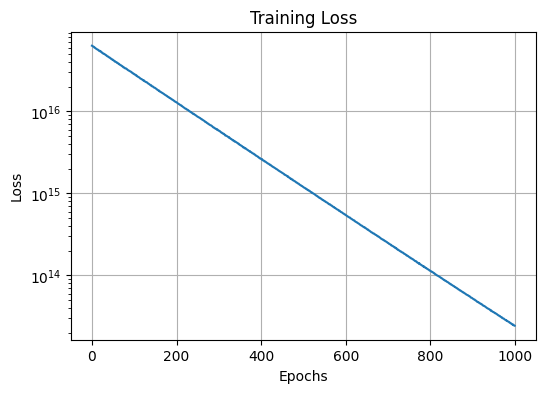

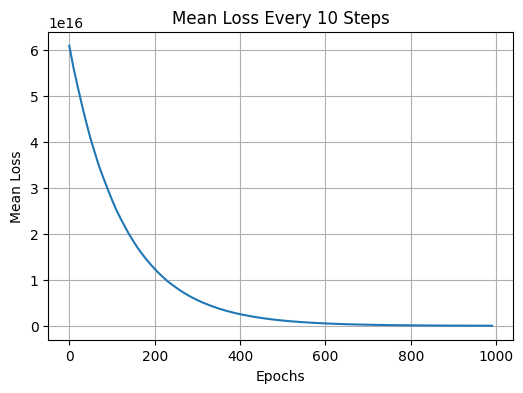

In [ ]:
# plot loss
def plot_loss(losses):
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.yscale("log")
    plt.grid()
    plt.savefig(os.path.join(save_dir, f"loss_plot_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
    plt.show()

# Call the function to plot loss
plot_loss(losses)

Predicted time spent:
Total test predictions:  20083
Total finite predictions:  20083
Predictions below threshold:  20083
Minimum 0.09371061487790315 and maximum 64.98372163963242

Predicted counts:
Total test predictions:  20083
Minimum 0.025 and maximum 138.565


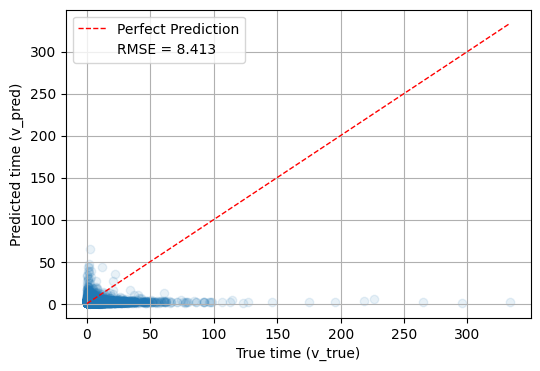

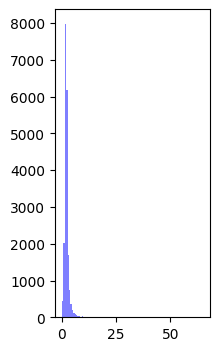

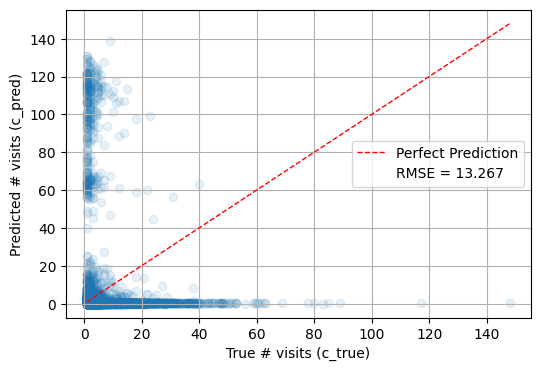

In [ ]:
# Plot predictions on test set
x_emb_test = x_emb_test.to(device).to(torch.float64)
d_demo_test = d_demo_test.to(device).to(torch.float64)
v_time_test = v_time_test.to(device).to(torch.float64)
v_time_test_log = v_time_test_log.to(device).to(torch.float64)
c_count_test = c_count_test.to(device).to(torch.float64)
v_time_mean = v_time_mean.to(device).to(torch.float64)
v_time_std = v_time_std.to(device).to(torch.float64)

predictive = Predictive(
    MixtureModel,
    guide=MixtureModelGuide,
    num_samples=200,                      # number of posterior draws
    return_sites=["obs_logv", "obs_c"]
)

# Draw posterior‐predictive samples
samples = predictive(x_emb_test_pca, d_demo_test, None, None, G, device)

# Compute the posterior mean prediction for each outcome
pred_v_log = samples["obs_logv"].mean(0)
pred_v_log = reverse_standardize_tensor(pred_v_log, v_time_mean, v_time_std)
pred_v = torch.exp(pred_v_log)
pred_v = pred_v.cpu().numpy()

pred_c = samples["obs_c"].mean(dim=0).cpu().numpy()

# Get the “true” values
v_time_test_log_reversed = reverse_standardize_tensor(v_time_test_log, v_time_mean, v_time_std)
true_v = torch.exp(v_time_test_log_reversed)
true_v   = true_v.cpu().numpy()

true_c = c_count_test.cpu().numpy()

threshold = 1e3

# Create a valid mask
print("Predicted time spent:")
print("Total test predictions: ", len(pred_v))
print("Total finite predictions: ", sum(np.isfinite(pred_v)))
print("Predictions below threshold: ", sum(pred_v < threshold))
print(f"Minimum {pred_v.min()} and maximum {pred_v.max()}")

print("\nPredicted counts:")
print("Total test predictions: ", len(pred_c))
print(f"Minimum {pred_c.min()} and maximum {pred_c.max()}")


mask = np.isfinite(pred_v) & (pred_v < threshold) & (true_v < threshold)
# Apply the mask to the true and predicted values
true_v = true_v[mask]
pred_v = pred_v[mask]

# Compute RMSE
rmse_v = np.sqrt(mean_squared_error(true_v, pred_v))
rmse_c = np.sqrt(mean_squared_error(true_c, pred_c))
# 6. Plot True vs Predicted for time

plt.figure(figsize=(6, 4))
plt.scatter(true_v, pred_v,  alpha=0.1)
plt.plot([true_v.min(), true_v.max()],
        [true_v.min(), true_v.max()],
            'r--', linewidth=1,label="Perfect Prediction")
plt.plot([], [], ' ', label=f"RMSE = {rmse_v:.3f}")

plt.xlabel("True time (v_true)")
plt.ylabel("Predicted time (v_pred)")
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_dir,f"time_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
plt.show()

plt.figure(figsize=(2, 4))
plt.hist(pred_v, bins=100, alpha=0.5, label="Predicted", color='blue')
plt.show()

# 7. Plot True vs Predicted for visits
plt.figure(figsize=(6, 4))
plt.scatter(true_c, pred_c, alpha=0.1)
plt.plot([true_c.min(), true_c.max()],
         [true_c.min(), true_c.max()],
          'r--', linewidth=1, label="Perfect Prediction")
plt.plot([], [], ' ', label=f"RMSE = {rmse_c:.3f}")
plt.xlabel("True # visits (c_true)")
plt.ylabel("Predicted # visits (c_pred)")
plt.grid()
plt.legend()
plt.savefig(os.path.join(save_dir,f"count_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
plt.show()

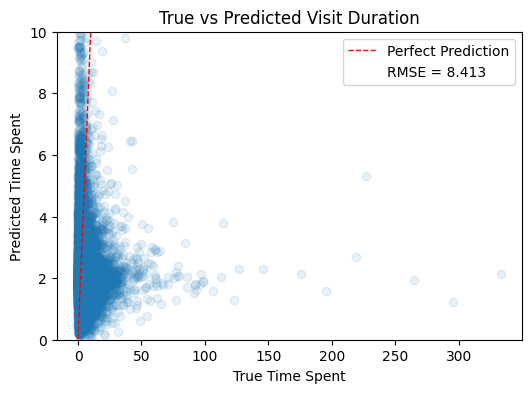

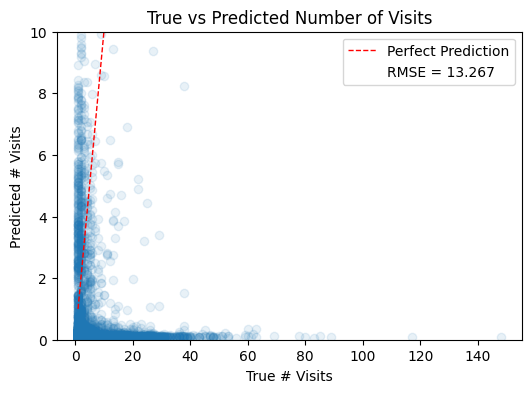

In [14]:
plt.figure(figsize=(6, 4))
plt.scatter(true_v, pred_v,  alpha=0.1)
plt.plot([true_v.min(), true_v.max()],
        [true_v.min(), true_v.max()],
            'r--', linewidth=1,label="Perfect Prediction")
plt.plot([], [], ' ', label=f"RMSE = {rmse_v:.3f}")

plt.xlabel("True Time Spent")
plt.ylabel("Predicted Time Spent")
plt.title("True vs Predicted Visit Duration")
plt.ylim(0,10)
plt.legend()
plt.savefig(os.path.join(save_dir,f"time_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(true_c, pred_c, alpha=0.1)
plt.plot([true_c.min(), true_c.max()],
         [true_c.min(), true_c.max()],
          'r--', linewidth=1, label="Perfect Prediction")
plt.plot([], [], ' ', label=f"RMSE = {rmse_c:.3f}")
plt.xlabel("True # Visits")
plt.ylabel("Predicted # Visits")
plt.ylim(0,10)
plt.title("True vs Predicted Number of Visits")
plt.legend()
plt.savefig(os.path.join(save_dir,f"count_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
plt.show()
